# Lesson 3: Decision Trees and Random Forests

In [109]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", None)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


In [110]:
raw_df = pd.read_csv("weather-data/weatherAUS.csv")

In [111]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [112]:
raw_df.dropna(subset = ['RainTomorrow'], inplace = True)

Data Preparation

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1351882740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = pd.to_datetime(raw_df['Date']).dt.year, palette = 'Pastel2')


<Axes: title={'center': 'Distribution of Data Points by Year'}, xlabel='Date', ylabel='count'>

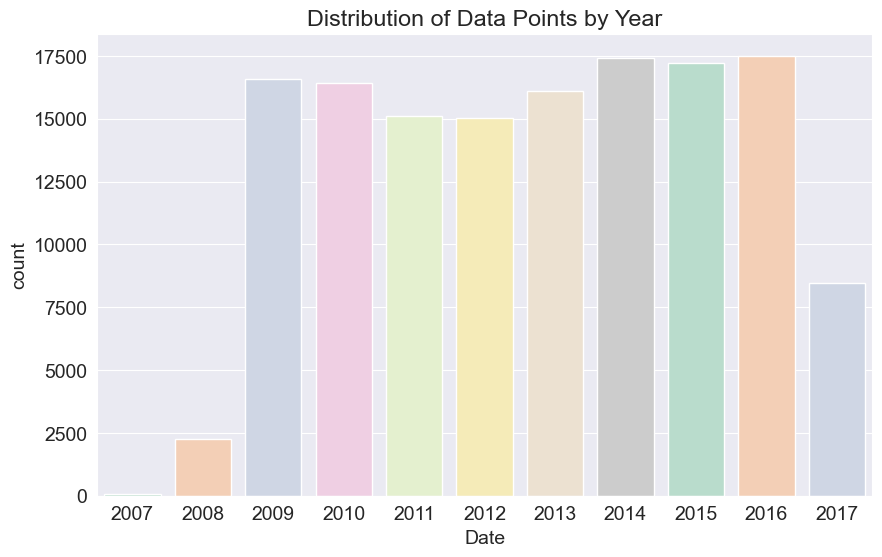

In [113]:
plt.title("Distribution of Data Points by Year")
sns.countplot(x = pd.to_datetime(raw_df['Date']).dt.year, palette = 'Pastel2')

In [114]:
#Until 2014 for the training set, 2015 for validation, and 2016-2017 for the testing set
year = pd.to_datetime(raw_df['Date']).dt.year

train_df = raw_df[year < 2015]
valid_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [115]:
train_df.shape, valid_df.shape, test_df.shape

((98988, 23), (17231, 23), (25974, 23))

In [116]:
raw_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [117]:
X_columns = raw_df.columns[1:-1]
y_columns = 'RainTomorrow'

In [118]:
X_train = train_df[X_columns]
y_train = train_df[y_columns]

In [119]:
X_valid = valid_df[X_columns]
y_valid = valid_df[y_columns]

In [120]:
X_test = test_df[X_columns]
y_test = test_df[y_columns]

In [121]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((98988, 21), (98988,), (17231, 21), (17231,), (25974, 21), (25974,))

In [122]:
numerical_columns = X_train.select_dtypes(include = np.number).columns.to_list()
categorial_columns = X_train.select_dtypes(include = object).columns.to_list()

In [123]:
numerical_columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [124]:
categorial_columns

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Imputing Values

In [125]:
from sklearn.impute import SimpleImputer

In [126]:
imputer = SimpleImputer(strategy = 'mean').fit(X_train[numerical_columns])

In [127]:
X_train[numerical_columns] = imputer.transform(X_train[numerical_columns])
X_valid[numerical_columns] = imputer.transform(X_valid[numerical_columns])
X_test[numerical_columns] = imputer.transform(X_test[numerical_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = imputer.transform(X_train[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numerical_columns] = imputer.transform(X_valid[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:3: SettingWithCopyWarning: 

In [128]:
X_train[numerical_columns].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Scaling Values

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler(feature_range = (0, 1)).fit(X_train[numerical_columns])

In [131]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_valid[numerical_columns] = scaler.transform(X_valid[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numerical_columns] = scaler.transform(X_valid[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:3: SettingWithCopyWarning: 
A va

In [132]:
X_train[numerical_columns].describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Encoding Categorical Data

In [133]:
categorial_columns

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [134]:
from sklearn.preprocessing import OneHotEncoder

In [135]:
X_train.fillna('Unknown', inplace = True)
X_valid.fillna('Unknown', inplace = True)
X_test.fillna('Unknown', inplace = True)

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna('Unknown', inplace = True)
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.fillna('Unknown', inplace = True)
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [136]:
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore').fit(X_train[categorial_columns])

In [137]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=

In [138]:
encoded_columns = encoder.get_feature_names_out(categorial_columns).tolist()

In [139]:
encoded_columns

['Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Location_Perth',
 'Location_PerthAirport',
 'Location_Portland',
 'Location_Richmond',
 'Location_Sale',
 'Location_SalmonGums',
 'Location_Sydney',
 'Location_SydneyAirport',
 'Location_Townsville',
 'Location_Tuggeranong',
 'Location_Uluru',
 'Location_WaggaWagga',
 'Location_Walpole',
 'Locat

In [140]:
X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
X_valid[encoded_columns] = encoder.transform(X_valid[categorial_columns])
X_test[encoded_columns] = encoder.transform(X_test[categorial_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: PerformanceWarning: DataFrame is high

In [141]:
#Final Step, Drop the textual categorical columns
X_train = X_train[numerical_columns + encoded_columns]
X_valid = X_valid[numerical_columns + encoded_columns]
X_test = X_test[numerical_columns + encoded_columns]

In [142]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Unknown,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064161,0.531618,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490495,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.375000,0.559387,0.000000,0.064161,0.531618,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478672,0.490495,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.504717,0.570881,0.000000,0.064161,0.531618,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478672,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.417453,0.614943,0.000000,0.064161,0.531618,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478672,0.490495,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

Training Decision Trees

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
model = DecisionTreeClassifier(random_state = 42)

In [145]:
model = model.fit(X_train, y_train)

Evaluation

In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [147]:
y_train_preds = model.predict(X_train)

In [148]:
pd.value_counts(y_train_preds)

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/3384252335.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_preds)


No     76707
Yes    22281
Name: count, dtype: int64

In [149]:
accuracy_score(y_train_preds, y_train)

0.9999797955307714

In [150]:
train_probs = model.predict_proba(X_train)

In [151]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(98988, 2))

In [152]:
model.score(X_valid, y_valid) #The model is overfitted on the training data and is not good at predicting on the validation and testing set

0.7934536591027799

In [153]:
model.score(X_test, y_test)

0.7733887733887734

In [154]:
#Visualize the decision tree
from sklearn.tree import plot_tree, export_text

[Text(0.5, 0.9, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.7, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'Sunshine <= 0.532\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.3, 'Pressure3pm <= 0.57\ngini = 0.363\nsamples = 12620\nvalue = [9618, 3002]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'Humidity3pm <= 0.513\ngini = 0.153\nsamples = 56632\nvalue = [51920, 4712]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'Humidity3pm <= 0.513\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.3, 'WindGustSpeed <= 0.318\ngini = 0.293\nsamples = 4299\nvalue = [3531, 768]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'WindGustSpeed <= 0.333\ngini = 0.478\nsample

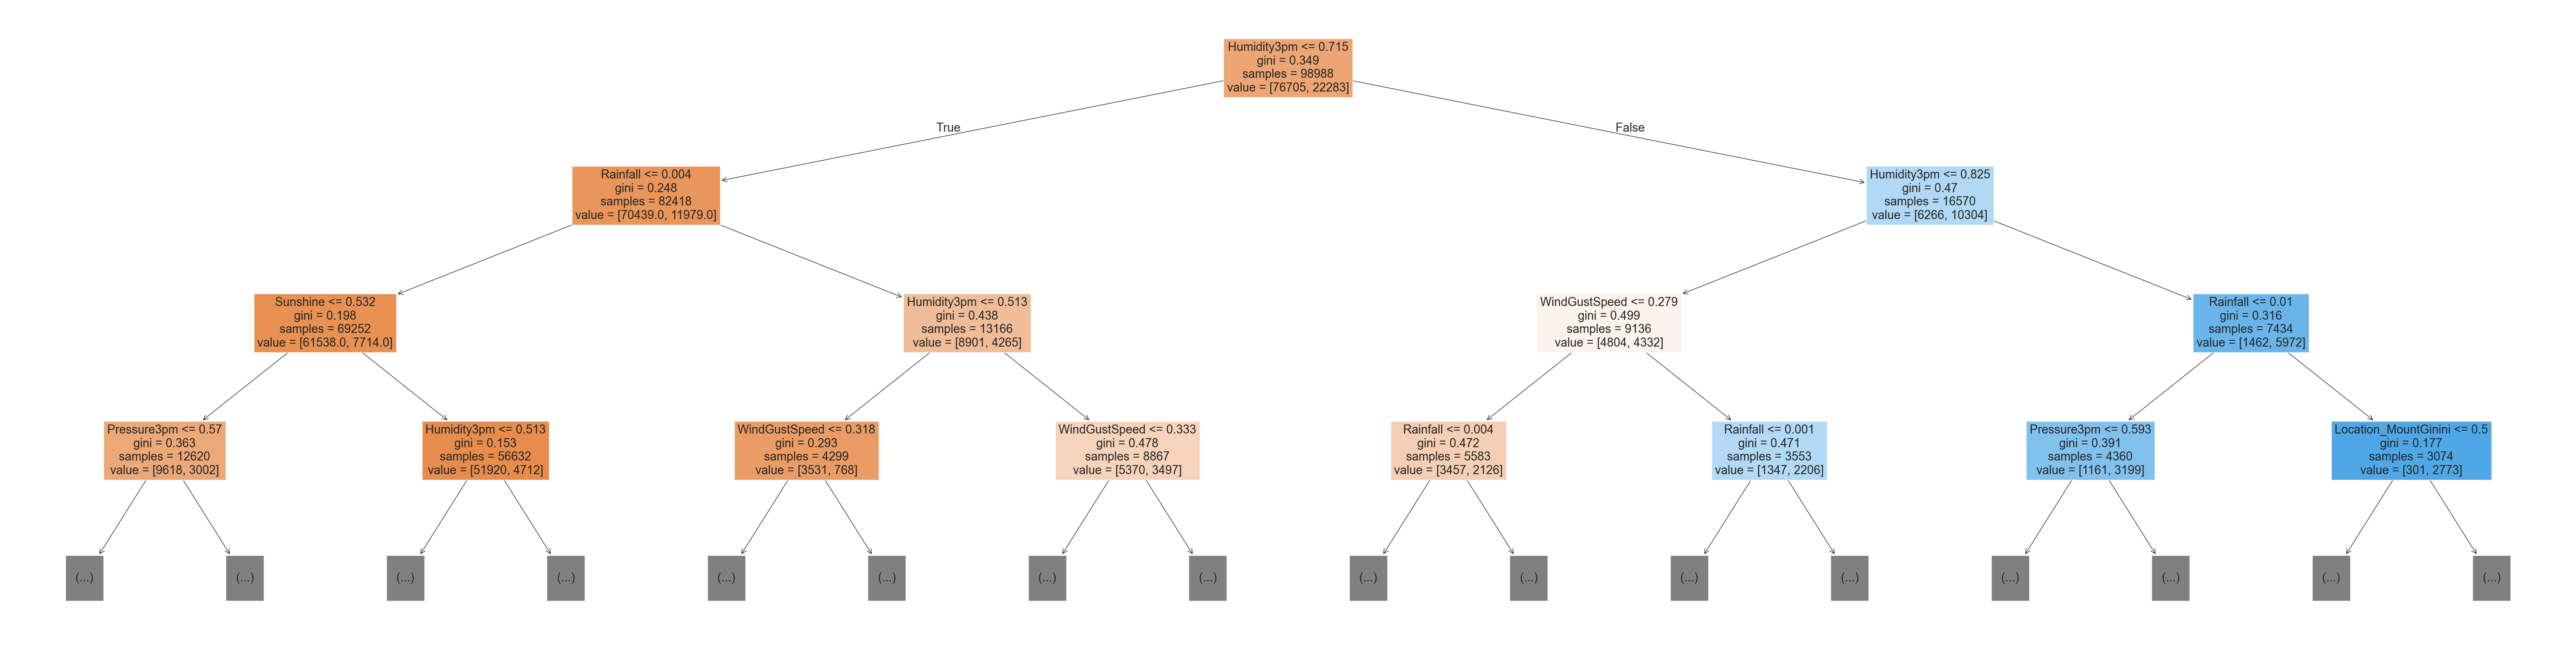

In [155]:
plt.figure(figsize = (80, 20))
plot_tree(model, feature_names = X_train.columns, max_depth = 3, filled = True)

In [156]:
model.tree_.max_depth

48

In [157]:
tree_text = export_text(model, max_depth = 10, feature_names = list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.57
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am <= 0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am >  0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

Feature Importance

In [158]:
model.feature_importances_

array([3.60942496e-02, 3.24849465e-02, 5.85022058e-02, 2.32941048e-02,
       5.04569335e-02, 5.56490616e-02, 2.72838810e-02, 2.99781901e-02,
       4.02599175e-02, 2.61227610e-01, 3.36460605e-02, 6.18331704e-02,
       1.46882754e-02, 1.83879646e-02, 3.38390142e-02, 2.85093715e-02,
       2.46807266e-03, 2.01018645e-03, 1.37944601e-03, 6.46899732e-04,
       1.47367937e-03, 1.22564024e-03, 5.90192615e-04, 1.69630043e-03,
       1.36712679e-03, 1.59946692e-03, 9.28969710e-04, 2.27703216e-03,
       1.68635809e-03, 1.90900634e-04, 1.02954381e-03, 1.50528736e-03,
       4.79266961e-04, 8.60664200e-04, 1.60660027e-03, 1.00805336e-03,
       8.73036636e-04, 8.15515513e-04, 1.70833521e-03, 2.02729741e-03,
       3.80144971e-04, 7.47734576e-04, 1.45534270e-03, 1.64404992e-03,
       1.66518121e-03, 8.75367720e-04, 9.39961034e-04, 1.51393401e-03,
       9.51705835e-04, 2.05702423e-03, 8.14775499e-04, 1.63968555e-03,
       9.51185098e-04, 1.27202685e-03, 1.31240733e-03, 4.40142133e-04,
      

In [159]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending = False)

In [160]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261228
11,Pressure3pm,0.061833
2,Rainfall,0.058502
5,WindGustSpeed,0.055649
4,Sunshine,0.050457
8,Humidity9am,0.040260
0,MinTemp,0.036094
14,Temp9am,0.033839
10,Pressure9am,0.033646
1,MaxTemp,0.032485


/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1490985763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(importance_df.head(10), x = 'importance', y = 'feature', palette = 'viridis')


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

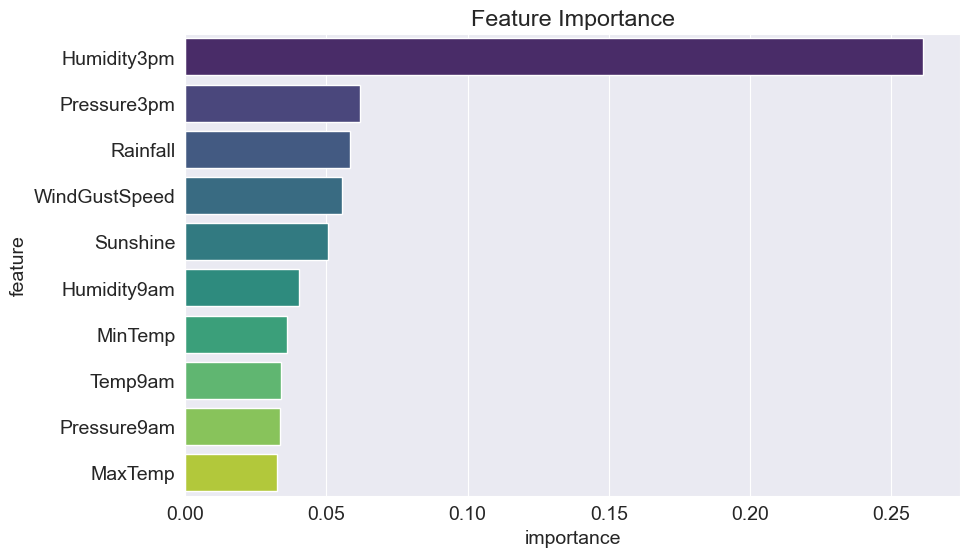

In [161]:
plt.title('Feature Importance')
sns.barplot(importance_df.head(10), x = 'importance', y = 'feature', palette = 'viridis')

Hyperparameter Tuning and Overfitting

In [162]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

In [163]:
#Go only 3 levels deep
model = DecisionTreeClassifier(random_state = 42, max_depth = 3)

In [164]:
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
model.score(X_valid, y_valid) #Model does better on the validation and testing set

0.8334397307178921

In [166]:
model.score(X_test, y_test)

0.8235928235928236

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]\nclass = No'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]\nclass = No'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Sunshine <= 0.532\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.363\nsamples = 12620\nvalue = [9618, 3002]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.153\nsamples = 56632\nvalue = [51920, 4712]\nclass = No'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.513\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]\nclass = No'),
 Text(0.3125, 0.125, 'gini = 0.293\nsamples = 4299\nvalue = [3531, 768]\nclass = No'),
 Text(0.4375, 0.125, 'gini = 0.478\nsamples = 8867\nvalue = [5370, 3497]\nclass = No'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]\nclass = Yes'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'WindGustSp

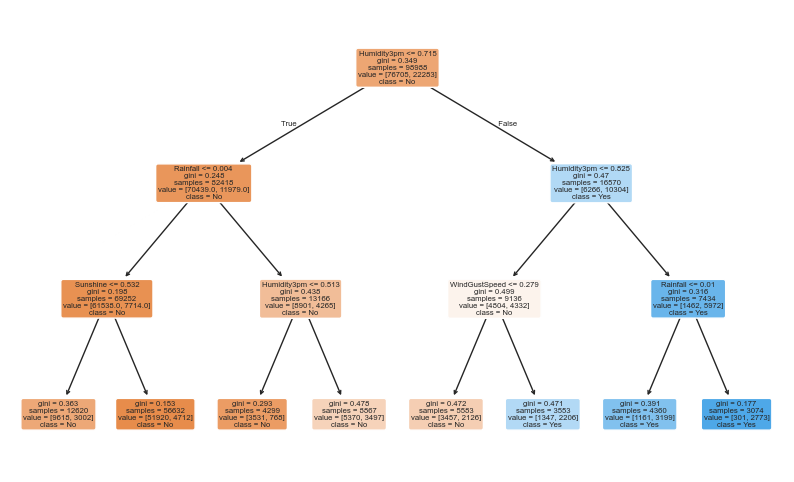

In [167]:
plot_tree(model, feature_names = X_train.columns, filled = True, rounded = True, class_names = model.classes_)

In [173]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth = md, random_state = 42)
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    valid_error = 1 - model.score(X_valid, y_valid)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': valid_error}


In [174]:
error_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [175]:
error_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.157971
8,9,0.140967,0.156636
9,10,0.132996,0.157217


In [177]:
error_df['Gap'] = abs(error_df['Validation Error'] - error_df["Training Error"])

In [180]:
error_df.sort_values(by = 'Gap', ascending = True)

,Max Depth,Training Error,Validation Error,Gap
5,6,0.156271,0.157275,0.001003
6,7,0.153312,0.154605,0.001294
3,4,0.165707,0.164355,0.001352
4,5,0.160676,0.159074,0.001602
2,3,0.170869,0.166560,0.004309
0,1,0.184315,0.177935,0.006380
1,2,0.179547,0.172712,0.006835
7,8,0.147806,0.157971,0.010165
8,9,0.140967,0.156636,0.015670
9,10,0.132996,0.157217,0.024221


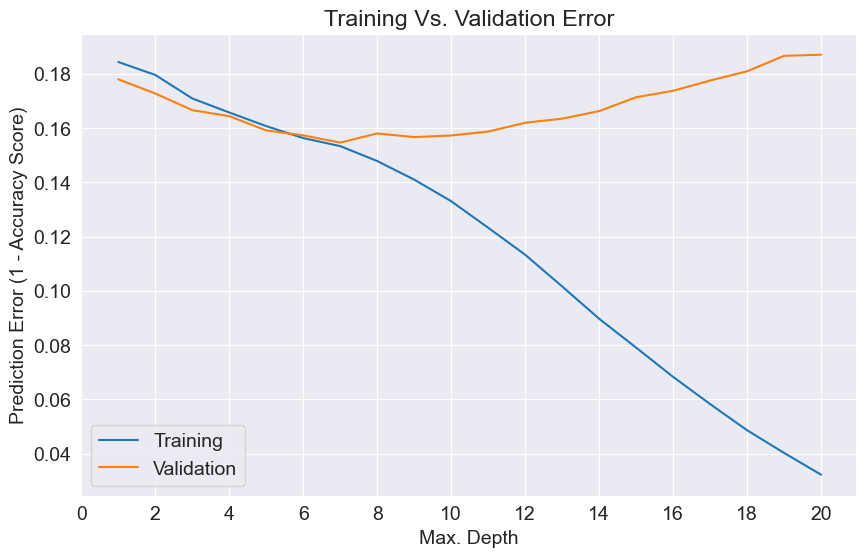

In [181]:
plt.figure()
plt.plot(error_df['Max Depth'], error_df['Training Error'])
plt.plot(error_df['Max Depth'], error_df['Validation Error'])
plt.title('Training Vs. Validation Error')
plt.xticks(range(0, 21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy Score)')
plt.legend(['Training', 'Validation'])

In [182]:
model = DecisionTreeClassifier(max_depth = 7, random_state = 42).fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_valid, y_valid)

(0.8466884874934335, 0.8453949277465034)

In [183]:
#Another way to control the complexity of a decision tree is to limit the number of leaf nodes. This allows varying depths
model = DecisionTreeClassifier(max_leaf_nodes = 128, random_state = 42)

In [184]:
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,128
,min_impurity_decrease,0.0
,class_weight,None


In [185]:
model.score(X_valid, y_valid)

0.8442342290058615

In [186]:
model.tree_.max_depth

12

In [198]:
#Find the combination that gives the best validation accuracy
def max_depth_leaf_node_error(md, mln):
    model = DecisionTreeClassifier(max_depth = md, max_leaf_nodes= mln, random_state = 42)
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    valid_error = 1 - model.score(X_valid, y_valid)
    return {'Max Depth': md, 'Max Leaf Nodes': mln, 'Training Error': train_error, 'Validation Error': valid_error}

In [199]:
error_df_2 = pd.DataFrame([max_depth_leaf_node_error(md, mln) for md in range(4, 15) for mln in range(20, 1000, 25)])

In [200]:
error_df_2['Gap'] = abs(error_df_2['Training Error'] - error_df_2['Validation Error'])

In [201]:
error_df_2.sort_values(by = 'Gap', ascending = True)

,Max Depth,Max Leaf Nodes,Training Error,Validation Error,Gap
81,6,45,0.157524,0.157565,0.000041
280,11,20,0.162757,0.162382,0.000375
40,5,20,0.162757,0.162382,0.000375
80,6,20,0.162757,0.162382,0.000375
160,8,20,0.162757,0.162382,0.000375
...,...,...,...,...,...
437,14,945,0.117691,0.157275,0.039584
398,13,970,0.118762,0.158609,0.039848
399,13,995,0.118257,0.158261,0.040005
438,14,970,0.117166,0.157449,0.040283


In [202]:
error_df_2['Score'] = error_df_2['Validation Error'] + (0.5 * error_df_2['Gap'])

In [203]:
error_df_2.sort_values(by = 'Score', ascending = True).head()

,Max Depth,Max Leaf Nodes,Training Error,Validation Error,Gap,Score
124,7,120,0.153362,0.154547,0.001185,0.155140
136,7,420,0.153312,0.154605,0.001294,0.155252
151,7,795,0.153312,0.154605,0.001294,0.155252
150,7,770,0.153312,0.154605,0.001294,0.155252
149,7,745,0.153312,0.154605,0.001294,0.155252


In [207]:
model = DecisionTreeClassifier(max_depth = 7, max_leaf_nodes = 120, random_state = 42).fit(X_train, y_train)

In [208]:
model.score(X_test, y_test)

0.8312158312158312

Training A Random Forest

In [209]:
#Multiple decision trees output decisions and we take the most common decision as the final output
from sklearn.ensemble import RandomForestClassifier

In [212]:
model = RandomForestClassifier(n_jobs = -1, random_state = 42)

In [213]:
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [214]:
model.score(X_train, y_train)

0.9999595910615429

In [215]:
model.score(X_valid, y_valid)

0.8558412164122802

In [217]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [0.96, 0.04],
       [0.99, 0.01],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.96, 0.04]], shape=(98988, 2))

In [218]:
model.estimators_[0]

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,random_state,1608637542
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [219]:
len(model.estimators_)

100

[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\ngini = 0.347\nsamples = 62607\nvalue = [76887, 22101]'),
 Text(0.25, 0.625, 'Cloud9am <= 0.611\ngini = 0.262\nsamples = 48769\nvalue = [65102, 11926]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'WindDir9am_E <= 0.5\ngini = 0.212\nsamples = 36906\nvalue = [51301, 7031]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.755\ngini = 0.387\nsamples = 11863\nvalue = [13801.0, 4895.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'WindDir3pm_NNW <= 0.5\ngini = 0.497\nsamples = 13838\nvalue = [11785.0, 10175.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Temp3pm <= 0.358\ngini = 0.497\nsamples = 13246\nvalue = [11377, 9627]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'WindDir9am_ESE <= 0.5\ngini = 0.489\nsamples = 592\nvalue = [408, 548]'),
 Text(0.8125, 0.

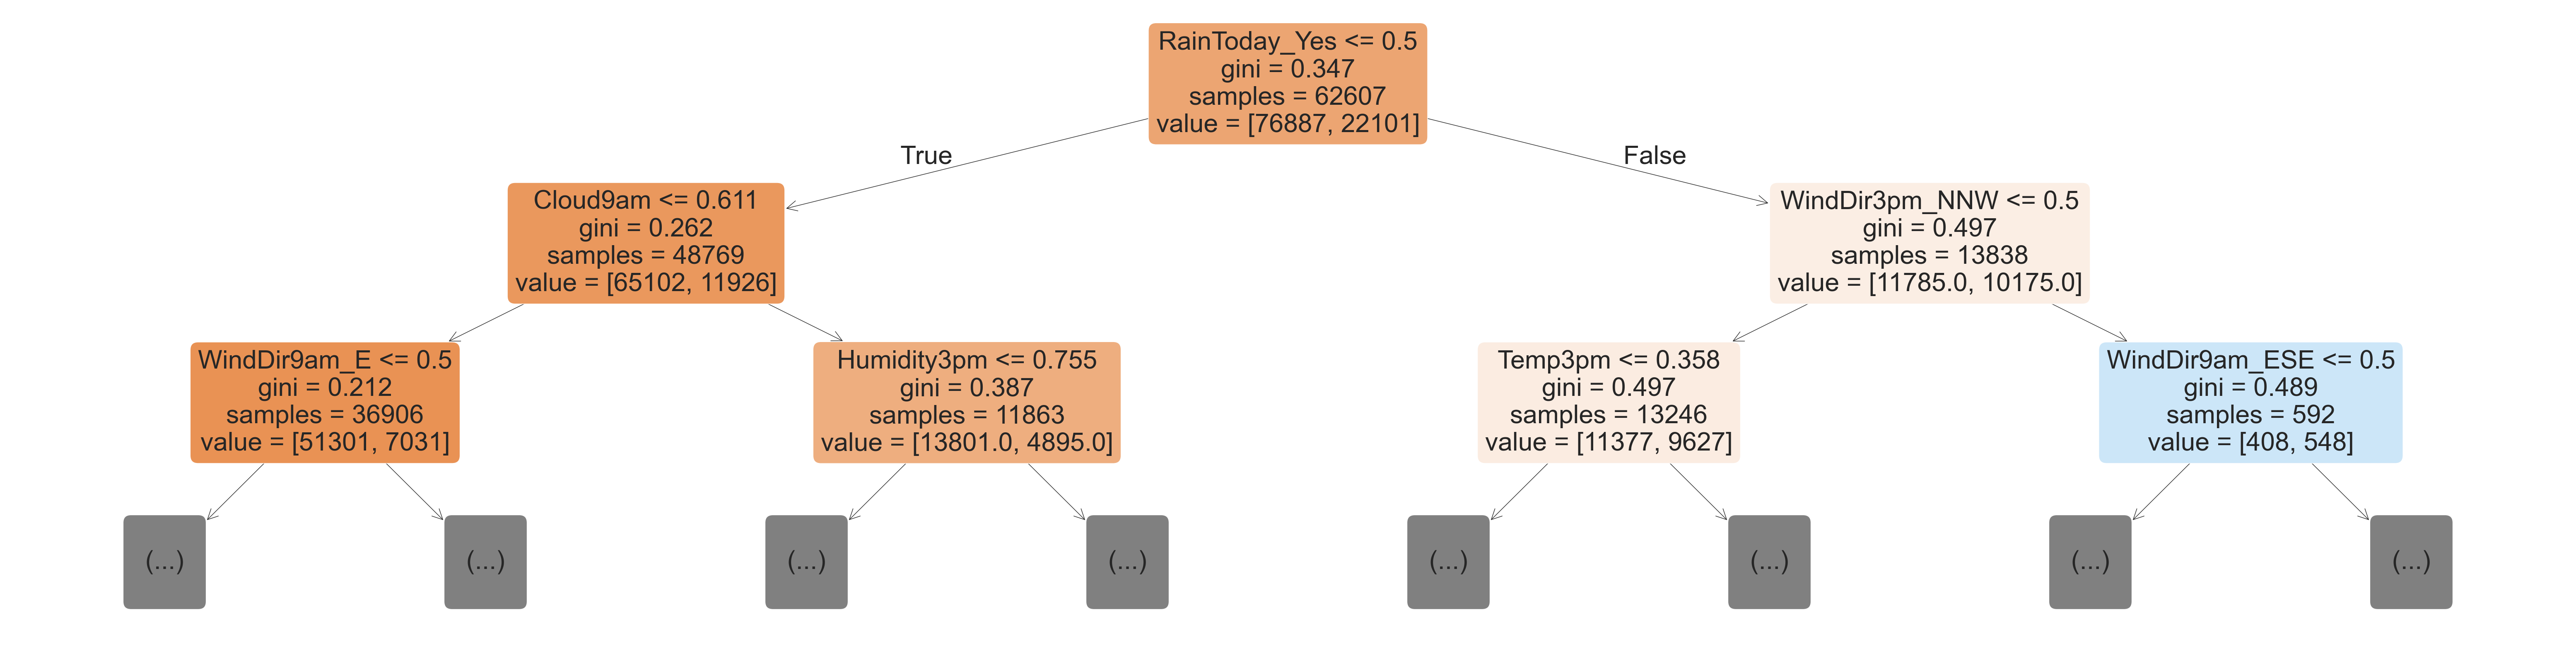

In [221]:
plt.figure(figsize = (80, 20))
plot_tree(model.estimators_[0], max_depth = 2, feature_names = X_train.columns, filled = True, rounded = True)

[Text(0.5, 0.875, 'Sunshine <= 0.423\ngini = 0.349\nsamples = 62448\nvalue = [76707, 22281]'),
 Text(0.25, 0.625, 'Humidity3pm <= 0.745\ngini = 0.499\nsamples = 11821\nvalue = [9860, 8914]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Humidity3pm <= 0.625\ngini = 0.45\nsamples = 7988\nvalue = [8315, 4320]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Evaporation <= 0.025\ngini = 0.377\nsamples = 3833\nvalue = [1545, 4594]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'RainToday_No <= 0.5\ngini = 0.278\nsamples = 50627\nvalue = [66847, 13367]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Pressure3pm <= 0.598\ngini = 0.474\nsamples = 9717\nvalue = [9457, 5962]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Sunshine <= 0.64\ngini = 0.202\nsamples = 40910\nvalue = [57390, 7405]'),
 Text(0.8125, 0.125, '\n  (...

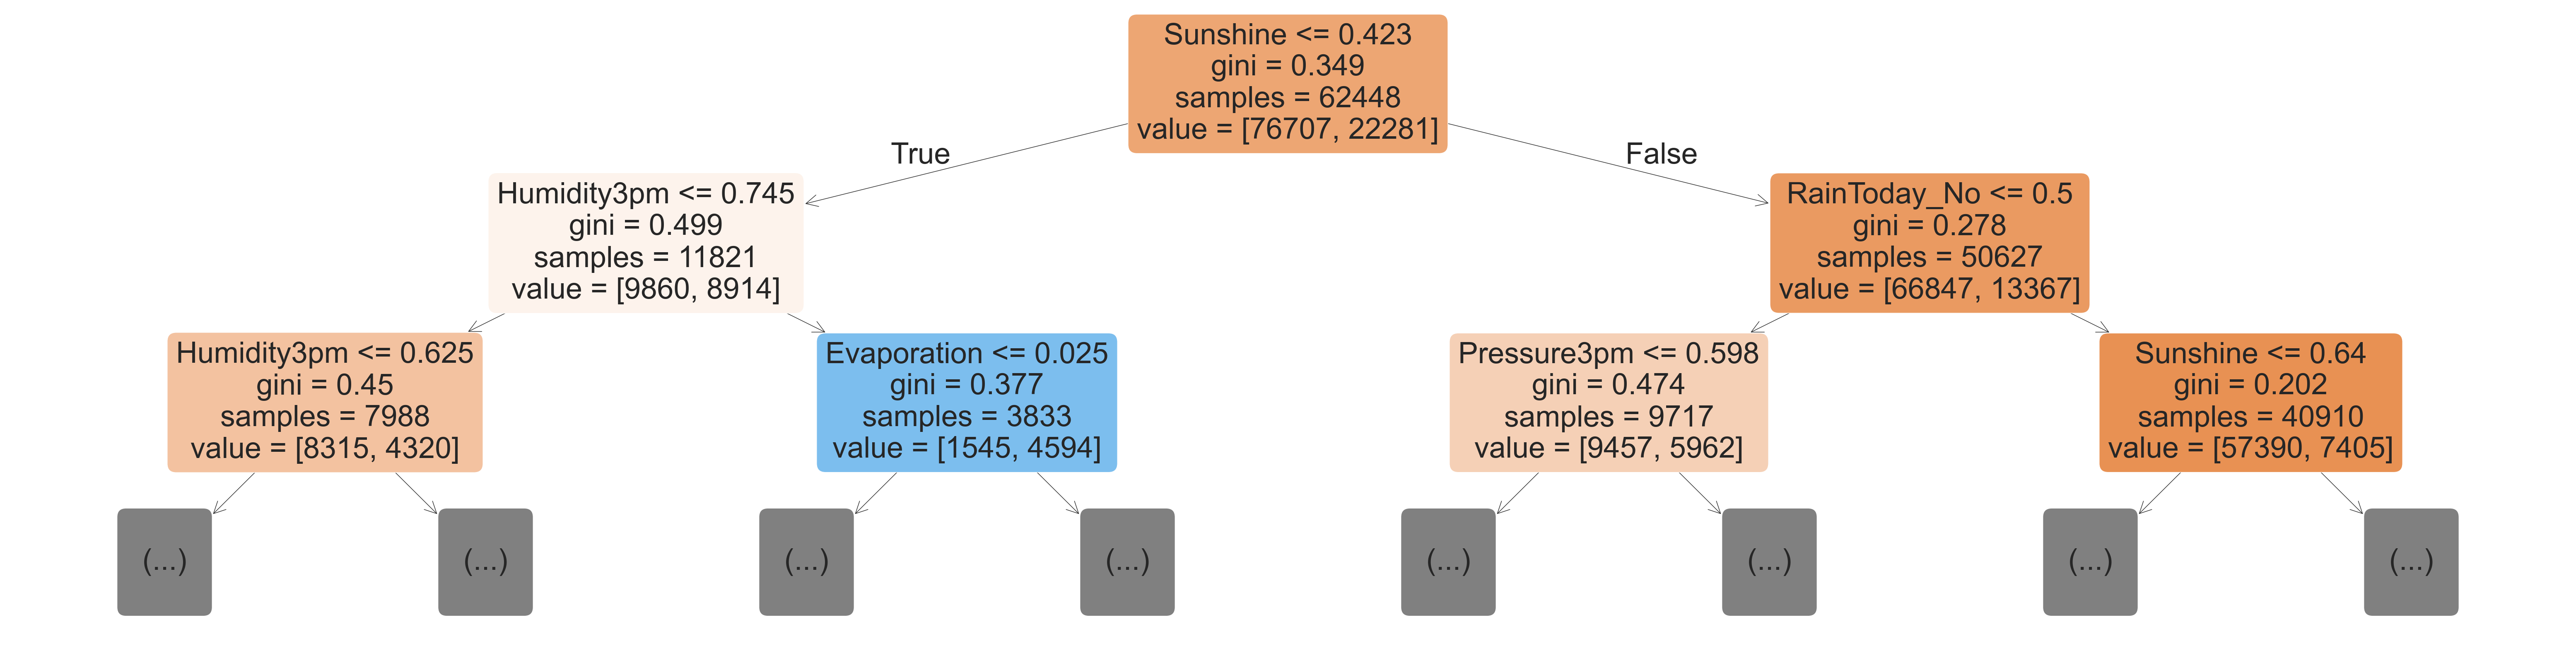

In [223]:
plt.figure(figsize = (80, 20))
plot_tree(model.estimators_[15], max_depth = 2, feature_names = X_train.columns, filled = True, rounded = True)

In [224]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by = 'importance', ascending = False)

<Axes: xlabel='feature'>

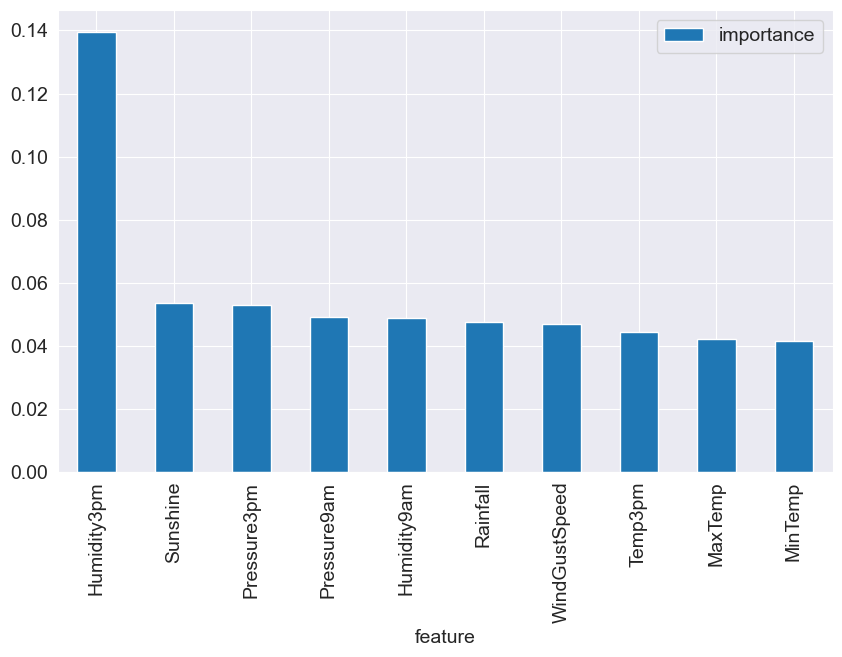

In [231]:
importance_df.head(10).plot(kind = 'bar', x = 'feature')